In [1]:
import const
import os
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Step 1: Load files

In [2]:
img_l = cv2.imread(os.path.join(const.DIR_IMG, 'task_2\\left_0.png'))
img_r = cv2.imread(os.path.join(const.DIR_IMG, 'task_2\\right_0.png'))

cam_mtx_l = np.loadtxt(os.path.join(const.DIR_PARAMS, 'left_camera_intrinsics_cam_mtx.csv'))
dst_l = np.loadtxt(os.path.join(const.DIR_PARAMS, 'left_camera_intrinsics_dst.csv'))
cam_mtx_r = np.loadtxt(os.path.join(const.DIR_PARAMS, 'right_camera_intrinsics_cam_mtx.csv'))
dst_r = np.loadtxt(os.path.join(const.DIR_PARAMS, 'right_camera_intrinsics_dst.csv'))

## Step 2: Find 3D-2D point correspondences

In [3]:
crn_l = cv2.findChessboardCorners(img_l, const.SIZE_GRID)[1]
crn_r = cv2.findChessboardCorners(img_r, const.SIZE_GRID)[1]

In [4]:
obj_pt = np.concatenate((
        np.mgrid[0:const.SIZE_GRID[0], 0:const.SIZE_GRID[1]].T.reshape(-1, 2),
        np.zeros((const.SIZE_GRID[0] * const.SIZE_GRID[1], 1))
    ), axis=1).astype('float32')

In [5]:
crn_l.shape

(54, 1, 2)

## Step 3: Stereo Calibrate

In [6]:
params = cv2.stereoCalibrate(np.array([obj_pt]), np.array([crn_l]), np.array([crn_r]), cam_mtx_l, dst_l, cam_mtx_r, dst_r, (480, 640), flags=cv2.CALIB_FIX_INTRINSIC)

In [7]:
_, cam_mtx_l, dst_l, cam_mtx_r, dst_r, R, T, E, F = params

## Step 4: Verify calibration results

Undistort points using the camera and distortion matrices.

In [8]:
undist_crn_l = cv2.undistortPoints(crn_l, cam_mtx_l, dst_l)
undist_crn_r = cv2.undistortPoints(crn_r, cam_mtx_r, dst_r)

Generate matrices P1=[I|0] and P2=[R|t].

In [9]:
projection_l = np.concatenate((np.identity(3), np.zeros((3,1))), axis=1).astype('float32')
projection_r = np.concatenate((R, T), axis=1).astype('float32')

Triangulate the points.

In [10]:
points = cv2.triangulatePoints(projection_l, projection_r, undist_crn_l, undist_crn_r)
cartesian_points = points[:3] / points[3]

Plot the points.

In [11]:
def plot_camera(ax, R=np.identity(3), T=np.zeros((3,1))):
    # Constants assumed
    tanx, tany, f = 1, 1, 1
    
    points = np.asarray([
        (0,0,0),
        (-tanx, -tany, 1),
        (0,0,0),
        (-tanx, tany, 1),
        (0,0,0),
        (tanx, -tany, 1),
        (0,0,0),
        (tanx, tany, 1),
        (tanx, -tany, 1),
        (-tanx, -tany, 1),
        (-tanx, tany, 1),
        (tanx, tany, 1)
    ])
    
    points = np.dot(points, R).T + T
    
    ax.plot(*points, color='black')

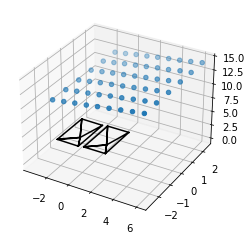

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*cartesian_points)
plot_camera(ax)
plot_camera(ax, R, T)

## Step 5: Undistort points

In [13]:
R_l, R_r, P_l, P_r, Q, roi_l, roi_r = cv2.stereoRectify(cam_mtx_l, dst_l, cam_mtx_r, dst_r, (640, 480), R, T)

## Step 6: Verify rectification results

In [14]:
maps_l = cv2.initUndistortRectifyMap(cam_mtx_l, dst_l, R_l, P_l, (640,480), cv2.CV_32FC1)
maps_r = cv2.initUndistortRectifyMap(cam_mtx_r, dst_l, R_r, P_r, (640,480), cv2.CV_32FC1)

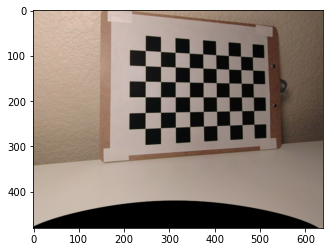

In [15]:
plt.imshow(cv2.cvtColor(cv2.remap(img_l, *maps_l, cv2.INTER_LINEAR), cv2.COLOR_BGR2RGB))

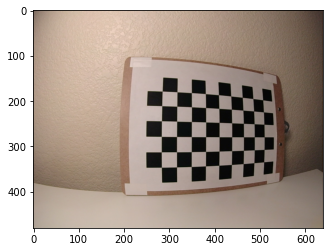

In [16]:
plt.imshow(cv2.cvtColor(img_l, cv2.COLOR_BGR2RGB))

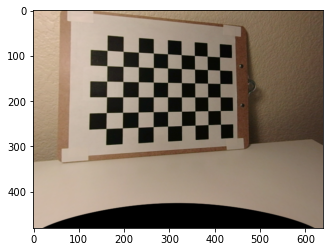

In [17]:
plt.imshow(cv2.cvtColor(cv2.remap(img_r, *maps_r, cv2.INTER_LINEAR), cv2.COLOR_BGR2RGB))

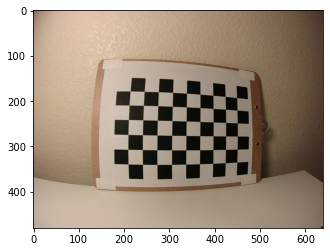

In [18]:
plt.imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))

array([[[ 89,  94, 115],
        [ 84,  89, 110],
        [ 88,  95, 115],
        ...,
        [ 40,  47,  65],
        [ 36,  47,  65],
        [ 25,  43,  63]],

       [[ 87,  93, 113],
        [ 83,  90, 110],
        [ 93, 100, 120],
        ...,
        [ 42,  49,  63],
        [ 40,  49,  65],
        [ 27,  40,  58]],

       [[ 90,  97, 115],
        [ 93, 101, 119],
        [ 95, 104, 122],
        ...,
        [ 45,  51,  64],
        [ 45,  51,  66],
        [ 34,  42,  59]],

       ...,

       [[144, 158, 170],
        [145, 159, 171],
        [147, 161, 173],
        ...,
        [106, 125, 142],
        [107, 125, 142],
        [ 98, 114, 131]],

       [[145, 158, 170],
        [146, 159, 171],
        [148, 161, 173],
        ...,
        [106, 126, 143],
        [107, 125, 142],
        [ 95, 113, 130]],

       [[148, 160, 172],
        [148, 160, 172],
        [149, 161, 173],
        ...,
        [105, 125, 142],
        [106, 125, 142],
        [ 95, 113, 130]]